In [1]:
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
df_initial = pd.read_csv('gnewt_morning_10feb.csv', delimiter=';')
df_initial.head().T

,0,1,2,3,4
altitude,0,0,0,0,0
co_a,267.5,267.5,265.9,265.9,270.8
co_w,191.8,190.2,192.6,191.8,191
pt,0,0,0,0,0
gps_fix,0,0,0,0,0
heading,0,0,0,0,0
humidity,14.1,14.1,14.1,14.1,14.1
latitude,0,0,0,0,0
lonet_bat,0,0,0,0,0
longitude,0,0,0,0,0


In [3]:
# filter by time
def filter_by_time(df):
    time = (df.timestamp >= '2017-02-09 23:00') & (df.timestamp <= '2017-02-10 12:00')
    return df[time]

df_initial.timestamp = pd.to_datetime(df_initial.timestamp)
df = filter_by_time(df_initial)
df = df.sort_values(by='timestamp')
df = df.set_index('timestamp')

In [4]:
# load calibration sheet from jukka
cal = pd.read_csv('V0_3_calibration.csv', index_col='ID')
cal = cal.T
# load fudge factors from colocation
colocation = pd.DataFrame(pd.read_csv('../alphasense_fudge_factors.csv', index_col=0))
colocation = colocation.T

# CO Conversion

In [5]:
def convert_co_ID(ID, CO_working_mv, CO_aux_mv, temp_correction = +1):
    # temp corretion is +1 up to 20 deg Cels, then -1, then -0.7 after 30C
    CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].CO_WE_ELECTRONIC_ZERO
    CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].CO_AUX_ELECTRONIC_ZERO
    #CO_SENSITIVITY = cal.loc[cal['ID'] == ID].CO_SENSITIVITY_mV_ppb; # mv/ppb
    CO_SENSITIVITY = cal[ID].CO_SENSITIVITY_nA_ppb; # nA/ppb
    CO_GAIN = cal[ID].CO_PCB_GAIN;

    scaled_working = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/CO_GAIN
    
    scaled_aux =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / CO_GAIN*temp_correction
    
    return  (scaled_working - scaled_aux)/CO_SENSITIVITY

In [6]:
df['co_ppb_alphasense'] = df[['id', 'co_a', 'co_w']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)

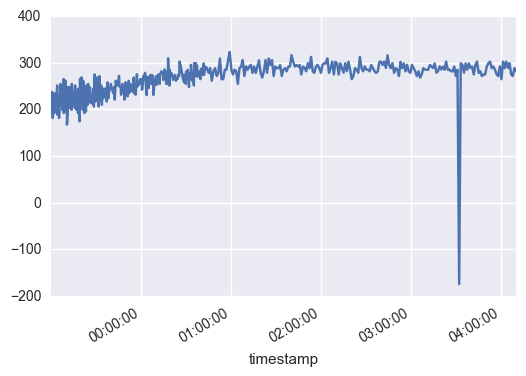

In [7]:
df.co_ppb_alphasense.plot()

## Different vehicles

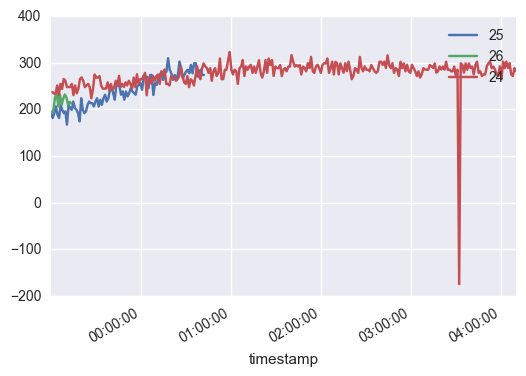

In [8]:
for car_id in df.id.unique():
    df[df.id == car_id].co_ppb_alphasense.plot()
ax = plt.gca()
ax.legend(df.id.unique())

## One hour averages

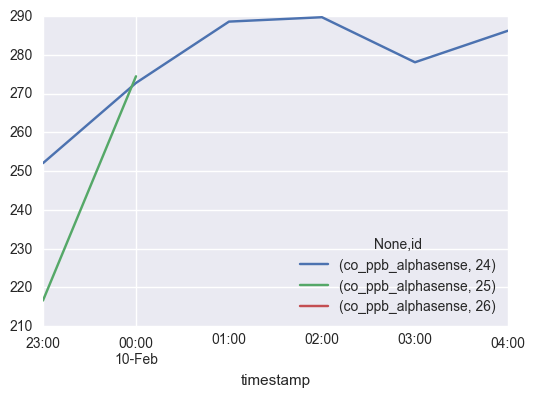

In [9]:
ds = xr.Dataset.from_dataframe(df.set_index(['id'], append=True))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
# df.co_ppb_alphasense.plot(linestyle='none', marker='o')
# df.co_ppb_alphasense.plot()
ds_mean_1h.co_ppb_alphasense.to_dataframe().unstack(level=1).plot()

# NO2 conversion

In [10]:
def convert_no2_ID(ID, NO2_working_mv, NO2_aux_mv, temp_correction = +1.09):
    # For A4 sensors: temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C
    
    NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].NO2_WE_ELECTRONIC_ZERO;
    NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal[ID].NO2_AUX_ELECTRONIC_ZERO;
    #NO2_SENSITIVITY = cal.loc[cal['ID'] == ID].NO2_SENSITIVITY_mV_ppb; # mv/ppb
    NO2_SENSITIVITY = cal[ID].NO2_SENSITIVITY_nA_ppb; # nA/ppb
    NO2_GAIN = cal[ID].NO2_PCB_GAIN;
    
    scaled_working = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/NO2_GAIN
    
    scaled_aux =  (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / NO2_GAIN*temp_correction
        
    return  (scaled_working - scaled_aux)/NO2_SENSITIVITY

In [11]:
df['no2_ppb_alphasense'] = df[['id', 'no2_a', 'no2_w']].apply(lambda x: convert_no2_ID(x.values[0], x.values[1], x.values[2]), axis=1)

## Different vehicles

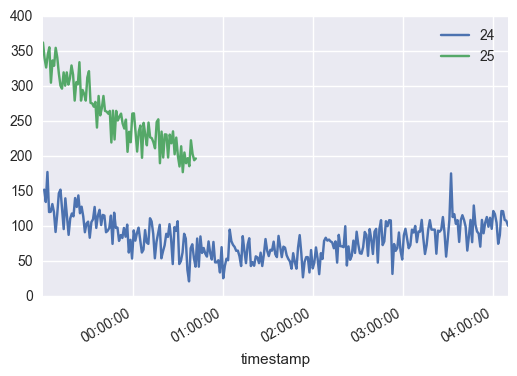

In [12]:
df[df.id == 24].no2_ppb_alphasense.plot()
df[df.id == 25].no2_ppb_alphasense.plot()
ax = plt.gca()
ax.legend([24, 25])